### Project Part 2: Pose Estimation on the Segmented Swimmer
    Use Yolov7 to detect the swimmers joints and model the post estimation

In [ ]:
pip install numpy==1.20.3

In [7]:
import torch
import torchvision
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import matplotlib.pyplot as plt

In [2]:
import sys
# Add the path to your YOLOv7 repository to the Python path
sys.path.append(r"C:/Users/Baron/Desktop/yolov7")

# Now, you can import the module or class you need
from models.yolo import Model  # Replace 'yolov7' with the actual model class name

In [4]:
 map_location=torch.device('cpu')

In [3]:
### Practice on one Image

In [4]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

def load_yolov7_model(weights_path, device):
    """
    Loads the YOLOv7 pose estimation model.
    Args:
        weights_path (str): Path to the YOLOv7 weights file.
        device (torch.device): The device to load the model on.
    Returns:
        model: Loaded YOLOv7 model.
    """
    # Load the model weights
    model_weights = torch.load(weights_path, map_location=device)
    model = model_weights['model']
    model.float().eval()

    # If CUDA is available, convert the model to half precision for faster inference
    if torch.cuda.is_available():
        model.half().to(device)
    return model

def detect_swimmer_pose(image_path, model, device):
    """
    Detects swimmer pose from an image using the YOLOv7 pose estimation model.
    Args:
        image_path (str): Path to the input image.
        model: Loaded YOLOv7 model.
        device (torch.device): The device to perform inference on.
    Returns:
        image_with_kpts: Image with keypoints and skeleton plotted.
        keypoints: Array of detected keypoints.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
        return None, None

    # Resize and pad the image to meet YOLOv7 requirements
    resized_image = letterbox(image, 960, stride=64, auto=True)[0]
    original_image = resized_image.copy()

    # Convert the image to a tensor
    transformed_image = transforms.ToTensor()(resized_image)
    transformed_image = torch.tensor(np.array([transformed_image.numpy()]))

    # Move the image to the device and convert to half precision if CUDA is available
    if torch.cuda.is_available():
        transformed_image = transformed_image.half().to(device)

    # Perform inference
    with torch.no_grad():
        output, _ = model(transformed_image)

    # Apply Non-Max Suppression to extract keypoints
    output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)

    # Convert output to keypoint format
    with torch.no_grad():
        keypoints = output_to_keypoint(output)

    # Draw the skeleton and keypoints on the image
    for idx in range(keypoints.shape[0]):
        plot_skeleton_kpts(original_image, keypoints[idx, 7:].T, 3)

    return original_image, keypoints

def run_pose_estimation(image_path, weights_path):
    """
    Runs YOLOv7 pose estimation on the given image.
    Args:
        image_path (str): Path to the image for pose estimation.
        weights_path (str): Path to the YOLOv7 pose estimation weights file.
    Returns:
        image_with_kpts: Processed image with keypoints and skeleton plotted.
        keypoints: Array of detected keypoints.
    """
    # Load YOLOv7 model
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    model = load_yolov7_model(weights_path, device)

    # Detect swimmer pose
    image_with_kpts, keypoints = detect_swimmer_pose(image_path, model, device)

    return image_with_kpts, keypoints


C:\Users\Baron\AppData\Local\Temp\ipykernel_31600\3814058545.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(weights_path, map_location=devic

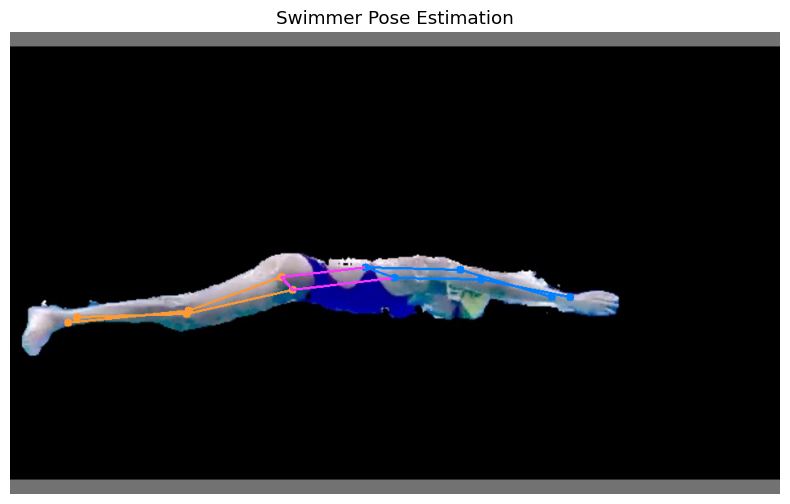

In [12]:
# Call the function
%matplotlib inline
image_path = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\segmented\breathstroke_pictures_seg\breathstroke_video_frame_00112_pp_segmented.jpg"  # Replace with the path to your segmented swimmer image
weights_path = 'C:/Users/Baron/Desktop/yolov7/yolov7-w6-pose.pt'  # Replace with your YOLOv7 weights path

processed_image, keypoints = run_pose_estimation(image_path, weights_path)


# Convert the processed image from BGR to RGB for Matplotlib
processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(processed_image_rgb)
plt.title("Swimmer Pose Estimation")
plt.axis('off')  # Turn off axes for better visualization
plt.show()

In [13]:
import os
import shutil
import cv2

def process_folder_images(input_folder, output_folder, weights_path):
    """
    Processes all images in the input folder using YOLOv7 pose estimation and saves the 
    processed images with keypoints to the output folder. Clears the output folder before running.
    
    Args:
        input_folder (str): Path to the folder containing input images.
        output_folder (str): Path to the folder to save processed images.
        weights_path (str): Path to the YOLOv7 weights file.
    """
    # Ensure the output folder is cleared before running
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # Load the YOLOv7 model
    device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
    model = load_yolov7_model(weights_path, device)

    # Process each image in the input folder
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)

        # Ensure the file is an image
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Skipping non-image file: {filename}")
            continue

        print(f"Processing {filename}...")

        # Perform pose estimation
        processed_image, keypoints = detect_swimmer_pose(input_path, model, device)
        
        if processed_image is None:
            print(f"Skipping {filename} due to an error in pose estimation.")
            continue

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, processed_image)

        # Append keypoints information if needed (e.g., save to a log file)
        with open(os.path.join(output_folder, "keypoints_log.txt"), "a") as log_file:
            log_file.write(f"{filename}: {keypoints}\n")

    print("Processing complete. Processed images saved to:", output_folder)

In [22]:
weights_path = 'C:/Users/Baron/Desktop/yolov7/yolov7-w6-pose.pt'  # Replace with your YOLOv7 weights path

backstroke_pictures_location_seg = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\ARCHIVE_1\send_to_pose\backstroke_pictures_seg_FINAL" 
breathstroke_pictures_location_seg = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\ARCHIVE_1\send_to_pose\breathstroke_pictures_seg_FINAL" 
butterfly_pictures_location_seg = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\ARCHIVE_1\send_to_pose\butterfly_pictures_seg_FINAL" 


backstoke_pictures_location_POSE = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\POSE\backstroke_POSE" 
breathstroke_pictures_location_POSE = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\POSE\breathstroke_POSE" 
butterfly_pictures_location_POSE = r"C:\Users\Baron\Documents\Grad_School\EE_267\term_project\pictures\videos_to_pictures\POSE\butterfly_POSE" 

#process_folder_images(backstroke_pictures_location_seg, backstoke_pictures_location_POSE, weights_path)
process_folder_images(breathstroke_pictures_location_seg, breathstroke_pictures_location_POSE, weights_path)
process_folder_images(butterfly_pictures_location_seg, butterfly_pictures_location_POSE, weights_path)

C:\Users\Baron\AppData\Local\Temp\ipykernel_31600\3814058545.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(weights_path, map_location=devic

Processing breathstroke_video_frame_00040_pp_segmented.jpg...
Processing breathstroke_video_frame_00048_pp_segmented.jpg...
Processing breathstroke_video_frame_00053_pp_segmented.jpg...
Processing breathstroke_video_frame_00058_pp_segmented.jpg...
Processing breathstroke_video_frame_00063_pp_segmented.jpg...
Processing breathstroke_video_frame_00064_pp_segmented.jpg...
Processing breathstroke_video_frame_00065_pp_segmented.jpg...
Processing breathstroke_video_frame_00067_pp_segmented.jpg...
Processing breathstroke_video_frame_00068_pp_segmented.jpg...
Processing breathstroke_video_frame_00069_pp_segmented.jpg...
Processing breathstroke_video_frame_00070_pp_segmented.jpg...
Processing breathstroke_video_frame_00071_pp_segmented.jpg...
Processing breathstroke_video_frame_00072_pp_segmented.jpg...
Processing breathstroke_video_frame_00073_pp_segmented.jpg...
Processing breathstroke_video_frame_00074_pp_segmented.jpg...
Processing breathstroke_video_frame_00075_pp_segmented.jpg...
Processi